In [134]:
%matplotlib inline
import matplotlib.pyplot as plt
from pyarrow import parquet as pq
import pyarrow as pa
import pandas as pd
from hostess.aws.s3 import Bucket
import os
import pdr
import numpy as np
from gPhoton.pipeline import execute_pipeline

import warnings
# Suppress all UserWarnings
warnings.filterwarnings('ignore', category=UserWarning)

from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from scipy.stats import gaussian_kde


1. Given an eclipse, pull the matching MCAT file
2. Generate a source position catalog from the MCAT
3. Run gPhoton2 photometry
4. Compare gPhoton2 vs. MCAT

In [ ]:
def get_mcat_file(eclipse,rootpath,
                  visit_metadata_fn='../glcat_v1_pipeline/visit_metadata.parquet',
                  mcat_manifest_fn = '../glcat_v1_pipeline/mcat_mast_list.csv',
                  bucket_name = 'uraniborg-sieve-7738937'):
    # given an eclipse, figure out the matching MCAT filename and then pull it from the bucket
    visit_metadata = pq.read_table(visit_metadata_fn)
    mcat_manifest = pd.read_csv(mcat_manifest_fn)
    row = visit_metadata.filter(pa.compute.equal(visit_metadata['ECLIPSE'], eclipse)).to_pydict()
    img, tilenum = int(row['IMG'][0]), int(row['TILENUM'][0])
    fp = mcat_manifest[mcat_manifest['source']=='visitI'][mcat_manifest['tilenum']==tilenum][mcat_manifest['img']==img]['fileNPath'].values[0]
    mcat_fn = fp.split('/')[-1]
    datapath = f"{rootpath}/e{str(eclipse).zfill(5)}"
    outpath = f"{datapath}/{mcat_fn}"
    if not os.path.exists(outpath):
        Bucket(bucket_name).get(mcat_fn,outpath)
    return outpath

'/Users/cm/github/glcat/mcat_comparison/data/e23458/MISWZS00_29076_0165_0002-xd-mcat.fits.gz'

In [45]:
datapath = f"/Users/cm/github/glcat/mcat_comparison/data"
mcat_path = get_mcat_file(23456,datapath)
mcat_path

'/Users/cm/github/glcat/mcat_comparison/data/e23456/MISWZS22_20403_0261_0005-xd-mcat.fits.gz'

In [46]:
def write_mcat_pos(eclipse,mcat_path):
    mcat_tbl = pdr.read(mcat_path)
    mcat_pos = mcat_tbl['GALEX_MERGED_SOURCE_LIST'][['alpha_j2000','delta_j2000']].rename(
        columns={'alpha_j2000':'ra','delta_j2000':'dec'})
    mcat_pos['eclipse']=np.full(len(mcat_pos),eclipse)
    mcat_pos_path = f'{datapath}/e{str(eclipse).zfill(5)}/e{str(eclipse).zfill(5)}_mcat_pos.csv'
    mcat_pos.to_csv(mcat_pos_path,index=None)
    return mcat_pos_path

In [47]:
mcat_cat_file = write_mcat_pos(eclipse,mcat_path)
mcat_cat_file

'/Users/cm/github/glcat/mcat_comparison/data/e23456/e23456_mcat_pos.csv'

In [98]:
def run_pipeline_from_cat(eclipse,mcat_cat_file,datapath,band='NUV',
                          aperture_sizes=[1.5, 2.3, 3.8, 6.0, 9.0, 12.8, 17.3],
                          compression="rice"):
    execute_pipeline(
        eclipse,
        band,
        depth=120,
        threads=4,
        local_root=datapath,
        recreate=False,
        aperture_sizes=aperture_sizes,
        write={"movie": True, "image": True},
        #coregister_lightcurves=True,
        photometry_only=False,
        compression=compression,
        suffix='mon',
        source_catalog_file=mcat_cat_file,
    )

In [104]:
for band in ['NUV','FUV']:
    run_pipeline_from_cat(eclipse,mcat_cat_file,datapath,band=band)#,compression='gzip')

starting timer
eclipse 23456 NUV  -- MIS; 0 leg(s)
using existing photon list(s): ['/Users/cm/github/glcat/mcat_comparison/data/e23456/e23456-nd-b00.parquet']
0.01 elapsed seconds, restarting timer
making images from /Users/cm/github/glcat/mcat_comparison/data/e23456/e23456-nd-b00.parquet
indexing data and making WCS solution
making full-depth image
making 120-second depth movies
29.33 elapsed seconds, restarting timer                     
Using specified catalog of 11431 sources.
1.19 elapsed seconds, restarting timer
1.07 elapsed seconds, restarting timer
extracting photometry from primary movie
extracting photometry from flag map
extracting photometry from edge map
writing exposure time table to /Users/cm/github/glcat/mcat_comparison/data/e23456/e23456-nd-f0120-b00-movie-exptime.csv
writing source table to /Users/cm/github/glcat/mcat_comparison/data/e23456/e23456-nd-f0120-b00-movie-photom-1_5-mon.csv
18.42 elapsed seconds, restarting timer
1.33 elapsed seconds, restarting timer
extr

In [105]:
def counts2mag(cps, band):
    scale = 18.82 if band == 'FUV' else 20.08
    with np.errstate(invalid='ignore'):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mag = -2.5 * np.log10(cps) + scale
    return mag

def mag2counts(mag, band):
    scale = 18.82 if band == 'FUV' else 20.08
    return 10.**(-(mag-scale)/2.5)

zpmag={'NUV':20.08, 'FUV':18.82}

In [106]:
phot = {'expt':
        pd.read_csv(f'{datapath}/e{str(eclipse).zfill(5)}/e{str(eclipse).zfill(5)}-nd-f0120-b00-movie-exptime.csv')}
aperture_sizes=[1.5, 2.3, 3.8, 6.0, 9.0, 12.8, 17.3]
for aper,aper_rad in enumerate(aperture_sizes):
    phot[f'APER_{int(aper+1)}'] = pd.read_csv(
        f'{datapath}/e{str(eclipse).zfill(5)}/e{str(eclipse).zfill(5)}-nd-f0120-b00-movie-photom-{str(aper_rad).replace(".","_")}-mon.csv'
    )

mcat_tbl = pdr.read(mcat_path)

(-5.0, 5.0)

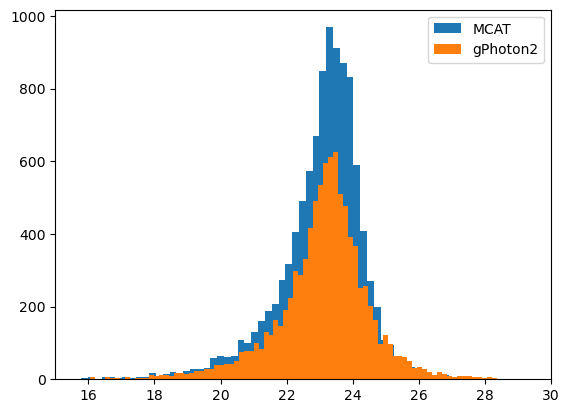

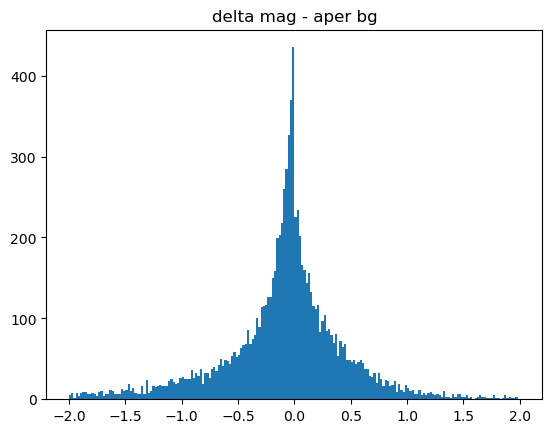

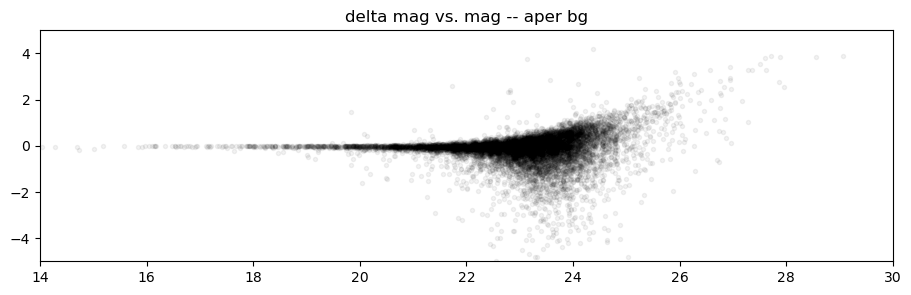

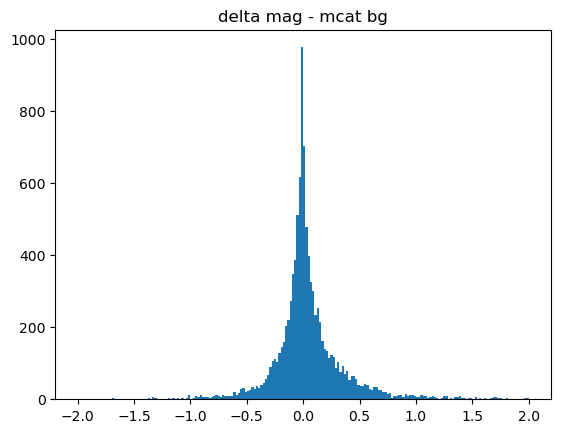

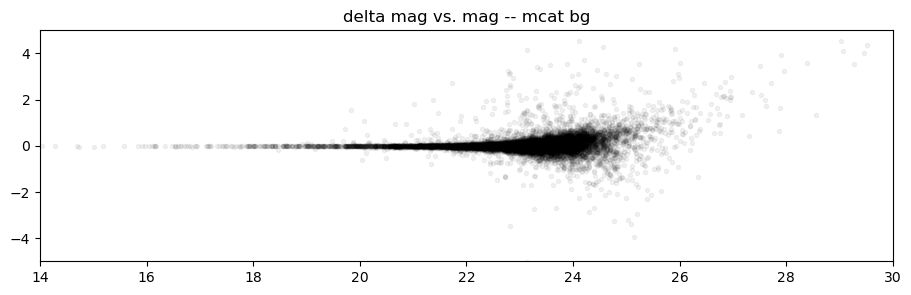

In [ ]:
aper = 5
catmags = mcat_tbl['GALEX_MERGED_SOURCE_LIST'][f'NUV_MAG_APER_{aper}'].values
ix = np.where((catmags>-50) & (catmags<50))# &
            #   (aper7['aperture_sum_mask']==0) &
            #   (aper7['aperture_sum_edge']==0))
#catmags[ix]=np.nan
plt.hist(catmags[ix]+zpmag['NUV'],bins=100,label='MCAT');

cps = phot['APER_5']['aperture_sum'].values[ix]/phot['expt'].expt.sum()
bg_counts = (9**2)*(phot['APER_7']['aperture_sum'].values-phot['APER_6']['aperture_sum'].values)/(17.3**2-12.8**2)
gphot_mag_bgsub = counts2mag((phot['APER_5']['aperture_sum'].values-bg_counts)[ix]/phot['expt'].expt.sum(),'NUV')
plt.hist(gphot_mag_bgsub,
         bins=100,range=[15,30],label='gPhoton2');
plt.xlim([15,30]);
plt.legend()

plt.figure()
plt.title('delta mag - aper bg')
plt.hist(catmags[ix]+zpmag['NUV']-gphot_mag_bgsub,bins=200,range=[-2,2]);

plt.figure(figsize=(11,3))
plt.title('delta mag vs. mag -- aper bg')
plt.plot(catmags[ix]+zpmag['NUV'],catmags[ix]+zpmag['NUV']-gphot_mag_bgsub,'k.',alpha=0.05)
plt.xlim([14,30])
plt.ylim([-5,5])

mcat_skybg = np.pi*(9**2)*mcat_tbl['GALEX_MERGED_SOURCE_LIST']['nuv_skybg'].values*phot['expt'].expt.sum()
gphot_mag_mcatbgsub = counts2mag((phot['APER_5']['aperture_sum'].values-mcat_skybg)[ix]/phot['expt'].expt.sum(),'NUV')
mag = catmags[ix]+zpmag['NUV']
delta_mag = mag-gphot_mag_mcatbgsub
plt.figure()
plt.title('delta mag - mcat bg')
plt.hist(delta_mag,bins=200,range=[-2,2]);

plt.figure(figsize=(11,3))
plt.title('delta mag vs. mag -- mcat bg')
plt.plot(mag,delta_mag,'k.',alpha=0.05)
plt.xlim([14,30])
plt.ylim([-5,5])


In [143]:
from itertools import product

from matplotlib import colormaps
from matplotlib.colors import ListedColormap
import numpy as np


def make_orange_teal_cmap():
    teal = (98, 252, 232)
    orange = (255, 151, 41)
    half_len = 256
    vals = np.ones((half_len * 2, 4))
    vals[0:half_len, 0] = np.linspace(orange[0] / half_len, 0, half_len)
    vals[0:half_len, 1] = np.linspace(orange[1] / half_len, 0, half_len)
    vals[0:half_len, 2] = np.linspace(orange[2] / half_len, 0, half_len)
    vals[half_len:, 0] = np.linspace(0, teal[0] / half_len, half_len)
    vals[half_len:, 1] = np.linspace(0, teal[1] / half_len, half_len)
    vals[half_len:, 2] = np.linspace(0, teal[2] / half_len, half_len)
    return ListedColormap(vals, name="orange_teal")

colormaps.register(cmap=make_orange_teal_cmap())

(-5.0, 5.0)

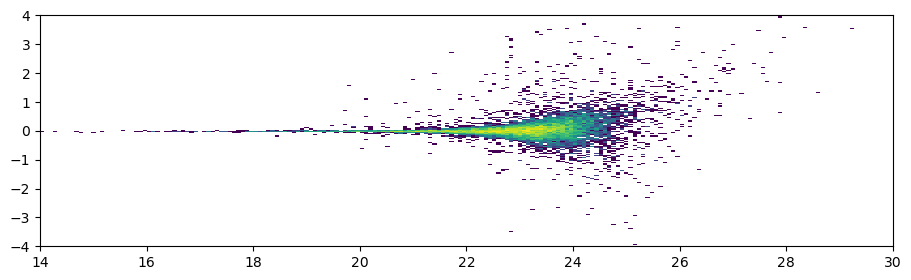

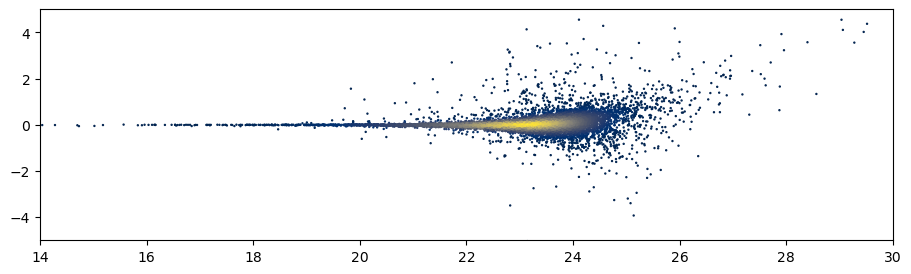

In [150]:
plt.figure(figsize=(11,3))
plt.hist2d(mag,delta_mag,bins=200,range=[[14,30],[-4,4]],cmap='viridis',norm=LogNorm());

ix = np.where(np.isfinite(mag) & np.isfinite(delta_mag))
xy = np.vstack([mag[ix],delta_mag[ix]])
z = gaussian_kde(xy)(xy)
plt.figure(figsize=(11,3))
#plt.plot(mag,delta_mag,'k.',alpha=0.03)
plt.scatter(mag[ix], delta_mag[ix], c=z, s=0.5, alpha=1, cmap="cividis")
plt.xlim([14,30])
plt.ylim([-5,5])


(-5.0, 5.0)

<Figure size 1200x1000 with 0 Axes>

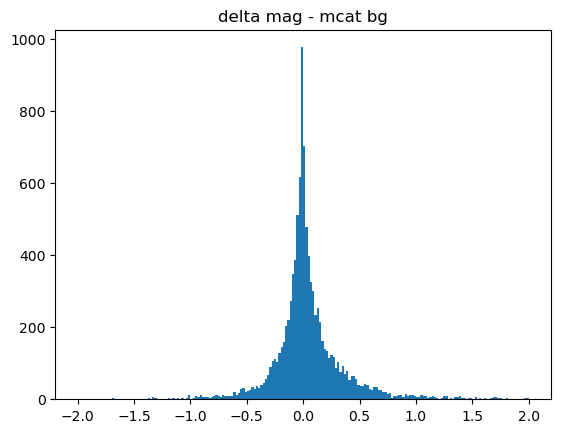

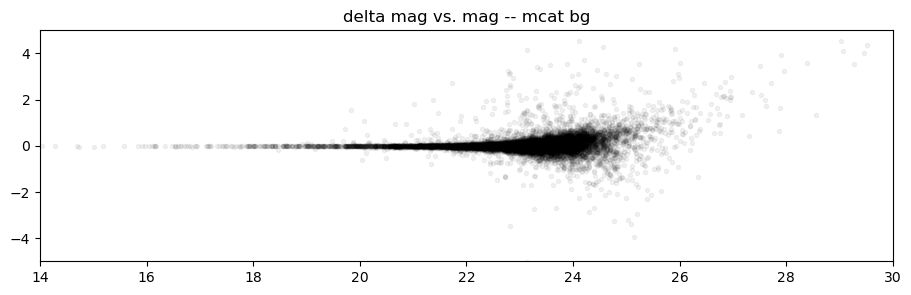

In [112]:
mcat_skybg = np.pi*(9**2)*mcat_tbl['GALEX_MERGED_SOURCE_LIST']['nuv_skybg'].values*phot['expt'].expt.sum()
gphot_mag_mcatbgsub = counts2mag((phot['APER_5']['aperture_sum'].values-mcat_skybg)[ix]/phot['expt'].expt.sum(),'NUV')
mag = catmags[ix]+zpmag['NUV']
delta_mag = mag-gphot_mag_mcatbgsub
fig = plt.figure(figsize=(12,10))
gs = GridSpec(6,6)


plt.figure()
plt.title('delta mag - mcat bg')
plt.hist(delta_mag,bins=200,range=[-2,2]);

plt.figure(figsize=(11,3))
plt.title('delta mag vs. mag -- mcat bg')
plt.plot(mag,delta_mag,'k.',alpha=0.05)
plt.xlim([14,30])
plt.ylim([-5,5])


In [109]:
len(mag)

10458